<a href="https://colab.research.google.com/github/SiriRRR/590-project/blob/main/cnn_class_generate%26%20eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q transformers torch
 !pip install datasets

In [6]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers.tokenization_utils_base import BatchEncoding
from typing import List, Tuple
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

In [7]:
dataset = load_dataset("cnn_dailymail",'3.0.0')
dataset

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [8]:

# load fine-tuned classification model before
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,AdamW, get_linear_schedule_with_warmup

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained('SiriRRR/news-classification', num_labels=4, output_hidden_states=True)
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [11]:
df_train = dataset['train'].to_pandas()[['article', 'highlights']]
df_test = dataset['test'].to_pandas()[['article', 'highlights']]
df_val = dataset['validation'].to_pandas()[['article', 'highlights']]

In [18]:
batch_size = 8
epochs = 4
lr_init = 5e-5
max_len = 256
warmup_steps = 3

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [19]:
def batch_data(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    lst = []
    l = len(data)//bsize
    for i in range(l):
        batch_text = data['highlights'][bsize*i:bsize*(i+1)].tolist()
        X = tokenizer.batch_encode_plus(batch_text, truncation =True, padding= 'max_length',max_length = max_len, add_special_tokens=True, return_tensors='pt')
        #Y = torch.LongTensor(data['label'][bsize*i:bsize*(i+1)].tolist())
        #s = batch_text
        lst.append((X))
    return lst

In [20]:
train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)
val_batches = batch_data(df_val, bsize=batch_size)

In [35]:
# get the prediction label by classification model before
def pred_label(batches):
  result_lst=[]

  # frozen model parameters(without train)
  for param in model.parameters():
    param.requires_grad_(False)
  
  # get output of each batch
  for item in batches:
    outputs = model(input_ids=item['input_ids'].to(device), attention_mask =item['attention_mask'].to(device))
    tmp = torch.argmax(outputs.logits, dim=1)
    result_lst = result_lst +tmp.tolist()

  return result_lst

In [41]:
# get prediction results for train data
train_class = pred_label(train_batches)

In [36]:
# get prediction results for validation data
val_class = pred_label(val_batches)

In [40]:
# get prediction results for test data
test_class = pred_label(test_batches)

In [43]:
print(len(train_class),len(val_class),len(test_class))

287112 13368 11488


In [44]:
(len(df_train),len(df_val),len(df_test))

(287113, 13368, 11490)

In [54]:
# check the records dropout in batch process
print(df_train['highlights'][287112])
print('')
print(df_test['highlights'][11488])
print('')
print(df_test['highlights'][11489])

Facebook page supporting tradition gains one million 'likes' in a day .
'Don't let the Netherlands' most beautiful tradition disappear,' it says .
UN has condemned the tradition claiming it reflects racial prejudice .

Apple sold more than 61 million iPhones in the quarter .
Apple didn't report any results for the new Apple Watch .
Believed around 2 million watches have been sold, according to estimates .

Angus Hawley's brother said his late sibling 'didn't have heart problems'
He is reported to have had a suspected heart attack in New York .
Angus was a father of four children - Lucia, Hamish, James and Sybella .
He had all four with Nicole Kidman's sister Antonia before their 2007 split .
Both 44-year-old Antonia and Angus, 46, remarried following their divorce .
Angus' death comes seven months after Dr. Antony Kidman's death .
Nicole and Antonia's father also died of a heart attack in Singapore .


In [55]:
# 0: "World",
# 1: "Sports",
# 2: "Business",
# 3: "Sci/Tech",

# add missing clas by hand
train_class.append(0)
test_class.append(3)
test_class.append(0)

In [56]:
print(len(train_class),len(val_class),len(test_class))

287113 13368 11490


In [57]:
df_train['class']= train_class
df_test['class']= test_class
df_val['class']= val_class

In [58]:
df_train

,article,highlights,class
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,2
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,3
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",2
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",3
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",1
...,...,...,...
287108,"The nine-year-old daughter of a black, unarmed...","Rumain Brisbon, 34, was killed after Phoenix p...",1
287109,Legalising assisted suicide is a slippery slop...,"Theo Boer, a European assisted suicide watchdo...",0
287110,A group calling itself 'The Women of the 99 Pe...,Ohio congressman criticised for 'condoning the...,0
287111,Most men enjoy a good pint of lager or real al...,The Black Country Ale Tairsters have been to 1...,2


In [59]:
df_test

,article,highlights,class
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,0
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",1
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,0
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,0
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,1
...,...,...,...
11485,Telecom watchdogs are to stop a rip-off that a...,Operators are charging up to 20p a minute - ev...,3
11486,The chilling reenactment of how executions are...,Bali Nine ringleaders will face the firing squ...,0
11487,It is a week which has seen him in deep water ...,Hardy was convicted of domestic abuse against ...,1
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,3


In [60]:
df_val

,article,highlights,class
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,3
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,1
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,1
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,1
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",0
...,...,...,...
13363,"It is the dream of many young children, the ch...","The town in Valley Center, San Diego, has been...",2
13364,It’s the type of encounter that can send panic...,Photographer Graham Hewer captured the jaw-dro...,3
13365,A group of tourists to the Bahamas enjoyed one...,The pigs swim through the crystal clear sea an...,3
13366,Pippa Middleton bundled up against the London ...,Kate's sister is back in London following 'cri...,2


In [63]:
# save
df_train.to_csv('cnn_train.csv',index=False)
df_test.to_csv('cnn_test.csv',index=False)
df_val.to_csv('cnn_val.csv',index=False)

In [66]:
## eda
# the number of hightlights with each class label
print(df_train['class'].value_counts())
print(df_val['class'].value_counts())
print(df_test['class'].value_counts())

0    107197
1     71327
3     64118
2     44471
Name: class, dtype: int64
1    5041
0    3937
3    2851
2    1539
Name: class, dtype: int64
1    4337
0    3498
3    2329
2    1326
Name: class, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ac4033a10>]],
      dtype=object)

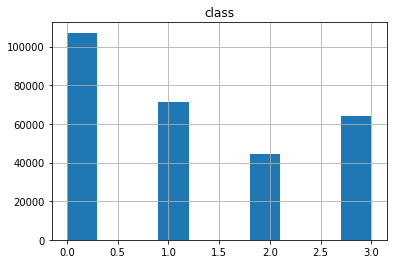

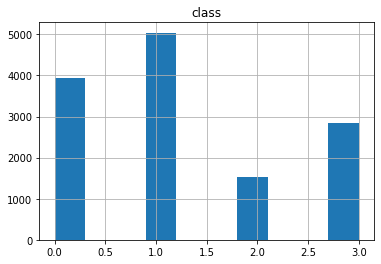

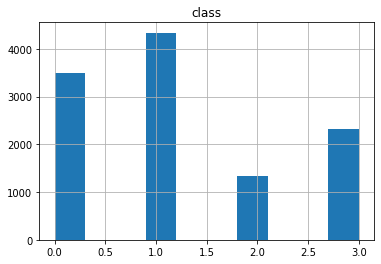

In [68]:
df_train.hist()
df_val.hist()
df_test.hist()

In [75]:
# merge test, train and validation dataframe together
df=pd.concat([df_train,df_val,df_test])

In [78]:
# explore the distribution of sentence length
# compute the length of hightlights
highlights_len = df['highlights'].apply(lambda x: len(x.split()))
article_len = df['article'].apply(lambda x: len(x.split()))

In [81]:
# print statistic summary for highlights
highlights_len.describe()

count    311971.000000
mean         51.972119
std          21.554799
min           4.000000
25%          38.000000
50%          49.000000
75%          60.000000
max        1440.000000
Name: highlights, dtype: float64

In [82]:
# print statistic summary for article
article_len.describe()

count    311971.000000
mean        690.883556
std         337.268343
min           8.000000
25%         441.000000
50%         630.000000
75%         877.000000
max        2347.000000
Name: article, dtype: float64

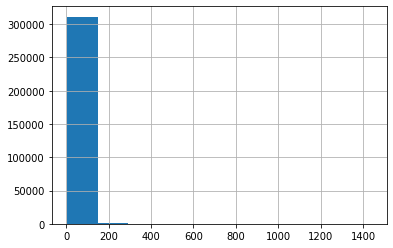

In [83]:
highlights_len.hist()

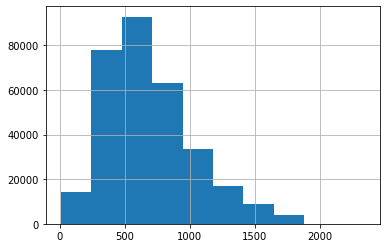

In [84]:
article_len.hist()

In [85]:
# find outlier for highlights
Q1_h=38;Q3_h=60
IQR_highlights = Q3_h-Q1_h
upper_bound_highlights = Q3_h + 1.5*IQR_highlights
lower_bound_highlights = Q1_h - 1.5*IQR_highlights
print(upper_bound_highlights, lower_bound_highlights)

93.0 5.0


In [86]:
# find outlier for article
Q1_a=441;Q3_a=877
IQR_article = Q3_a-Q1_a
upper_bound_article = Q3_a + 1.5*IQR_article
lower_bound_article = Q1_a - 1.5*IQR_article
print(upper_bound_article, lower_bound_article)

1531.0 -213.0


In [87]:
df['highlights_len']= highlights_len
df['article_len']= article_len

In [89]:
#remove outliers
df_new = df[(df['highlights_len'] <	upper_bound_highlights) & (df['highlights_len'] >	lower_bound_highlights) & (df['article_len'] <	upper_bound_article) & (df['article_len'] >	lower_bound_article)]

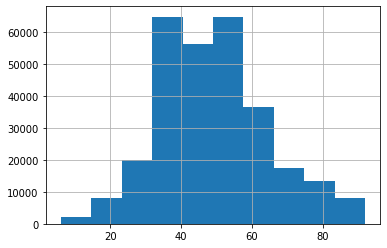

In [90]:
df_new['highlights_len'].hist()

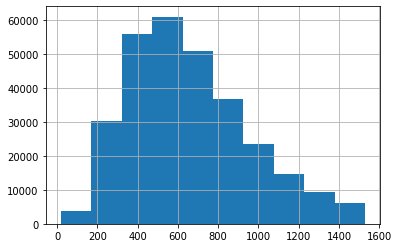

In [91]:
df_new['article_len'].hist()

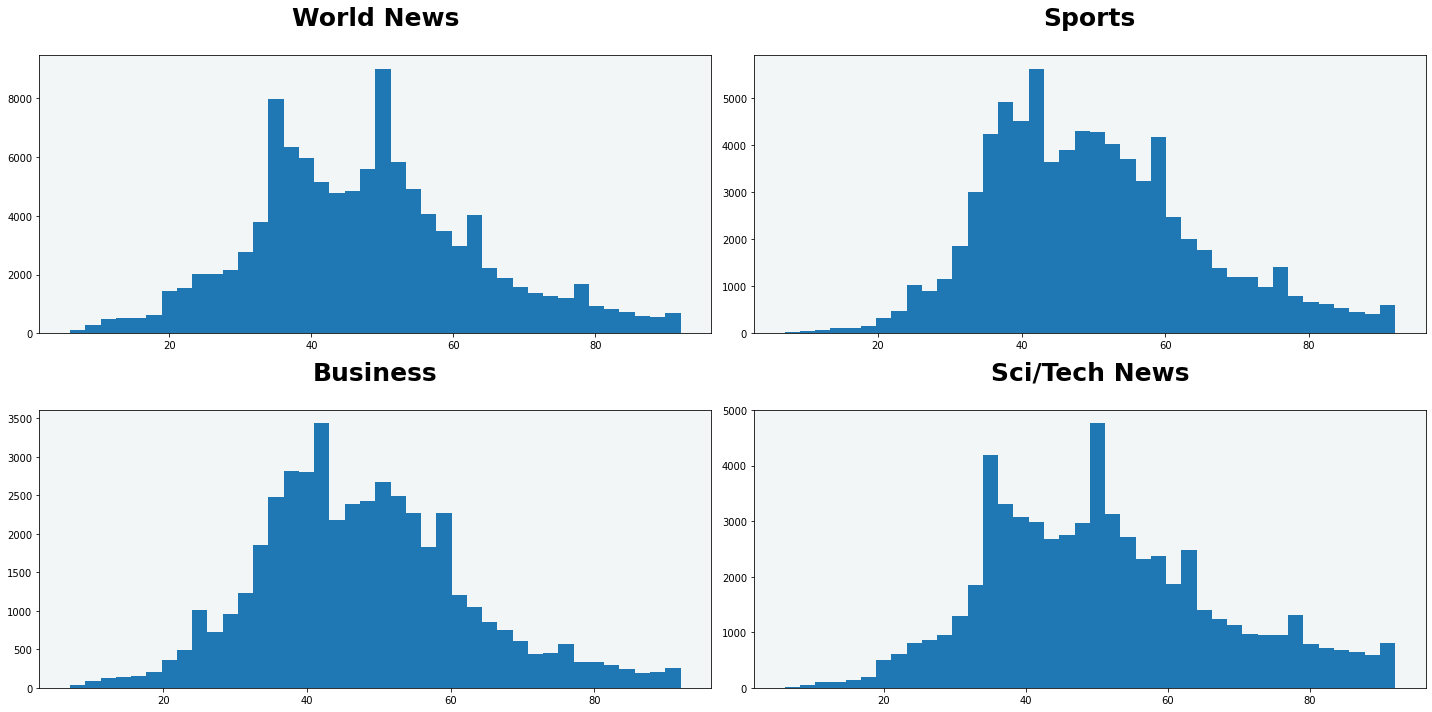

In [116]:
# highlights length distribution for different class news
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.facecolor']='#f3f6f7'
ax1=plt.subplot(221)
ax1.hist(df_new[(df_new['class']==0)]['highlights_len'],bins=40)
ax1.set_title("World News",fontsize = 25, fontweight='bold',pad=30)
ax2=plt.subplot(222)
ax2.hist(df_new[(df_new['class']==1)]['highlights_len'],bins=40)
ax2.set_title("Sports",fontsize = 25, fontweight='bold',pad=30)
ax3=plt.subplot(223)
ax3.hist(df_new[(df_new['class']==2)]['highlights_len'],bins=40)
ax3.set_title("Business",fontsize = 25, fontweight='bold',pad=30)
ax4=plt.subplot(224)
ax4.hist(df_new[(df_new['class']==3)]['highlights_len'],bins=40)
ax4.set_title("Sci/Tech News",fontsize = 25, fontweight='bold',pad=30)
plt.tight_layout()
plt.show()

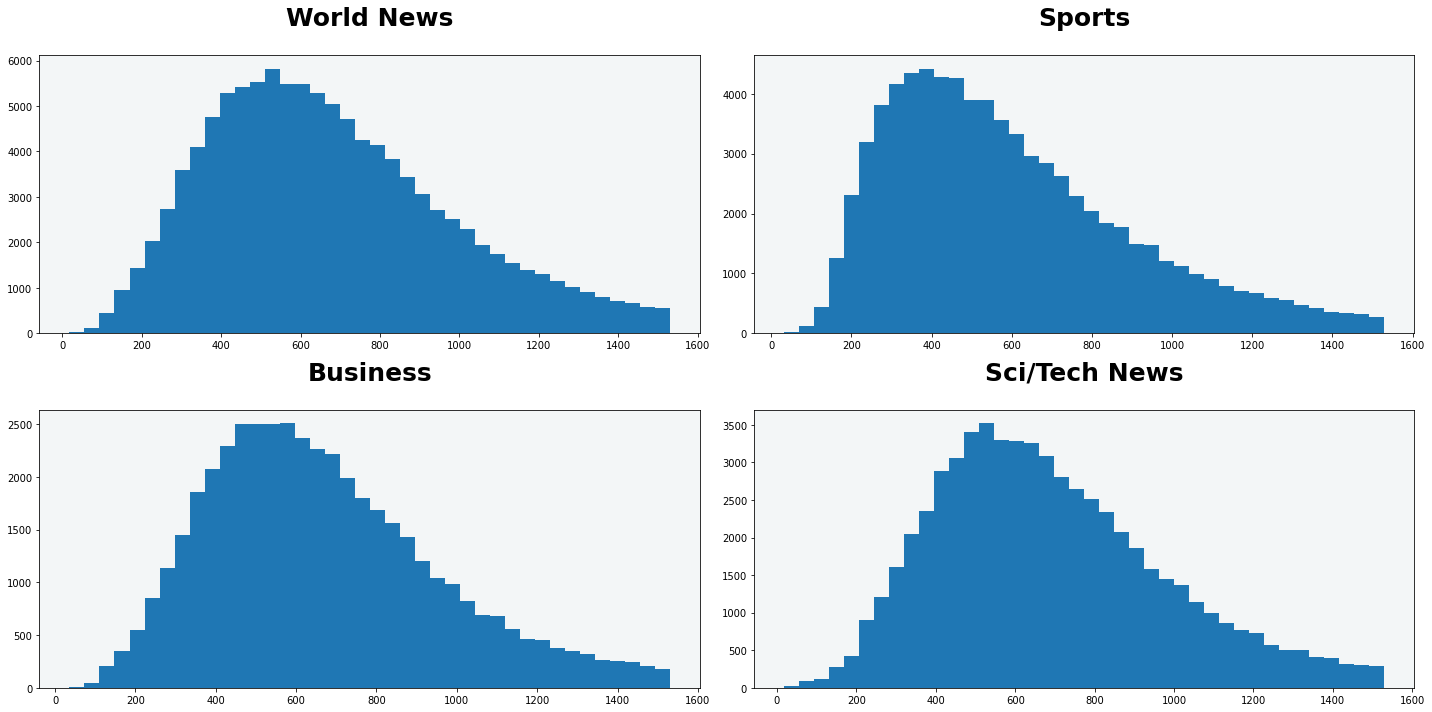

In [117]:
# article length distribution for different class news
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.facecolor']='#f3f6f7'
ax1=plt.subplot(221)
ax1.hist(df_new[(df_new['class']==0)]['article_len'],bins=40)
ax1.set_title("World News",fontsize = 25, fontweight='bold',pad=30)
ax2=plt.subplot(222)
ax2.hist(df_new[(df_new['class']==1)]['article_len'],bins=40)
ax2.set_title("Sports",fontsize = 25, fontweight='bold',pad=30)
ax3=plt.subplot(223)
ax3.hist(df_new[(df_new['class']==2)]['article_len'],bins=40)
ax3.set_title("Business",fontsize = 25, fontweight='bold',pad=30)
ax4=plt.subplot(224)
ax4.hist(df_new[(df_new['class']==3)]['article_len'],bins=40)
ax4.set_title("Sci/Tech News",fontsize = 25, fontweight='bold',pad=30)
plt.tight_layout()
plt.show()